Author: Michael Stoll\
6/20/24\
\
For this assignment, I am going to be using several different search processes (and grids) to evaluate different hyperparameters with a few classifiers and, eventually, find the best combination of classifier and hyperparameter set to provide the best accuracy for predicting my chosen target. I will delve deeper into the details of that in the upcoming markdowns, after I have explained the dataset.\
\
The dataset I've chosen for this assignment is actually the same one that I used for the exploratory data analysis assignment. This CSV, composed by NASA, is a spreadsheet of news articles describing landslides that have occurred across the globe. It contains a great many columns, such as Publisher or Date of Publishing, that are not useful to me in this context. So, I've elected to keep only 5 columns: landslide_category (how they officially describe how the land is moving), landslide_trigger (what caused the landslide), landslide_size, fatality_count, and injury_count, the last three of which are self-explanatory. Since all that I did in that assignment was clean up the data a bit, I didn't see any harm in reusing it and attempting to best predict the amount of injuries caused by a given landslide. I'm beginning to loathe typing the word 'landslide'.\
\
Fair warning: there's going to be a lot of preprocessing of data in the next cell. Most of the data is plaintext, which means I'm going to need to walk through and convert each instance of each plaintext into something that I can feed to a regression. Most of it is pretty straightforward, but notably there are two spots where several categories are lumped into the "other" category. These categories each comprise less than 100 of the 11,000 entries, so I've arbitrarily decided to designate them all to "other" for the sake of simplicity.

In [8]:
import numpy as np
import pandas as pd

data = pd.read_csv("Global_Landslide_Catalog_Export_20240606.csv", sep=",")
data = data[['landslide_category', 'landslide_trigger', 'landslide_size', 'fatality_count', 'injury_count']]
data = data.drop(data[(data['fatality_count'] > 33) | (data['injury_count'] > 10)].index)
data = data.dropna()
data['landslide_category'] = data['landslide_category'].str.replace("landslide", "1")
data['landslide_category'] = data['landslide_category'].str.replace("mudslide", "2")
data['landslide_category'] = data['landslide_category'].str.replace("rock_fall", "3")
data['landslide_category'] = data['landslide_category'].str.replace("complex", "4")
data['landslide_category'] = data['landslide_category'].str.replace("debris_flow", "5")
data['landslide_category'] = data['landslide_category'].str.replace("unknown", "0")
data['landslide_category'] = data['landslide_category'].str.replace("other|translational_slide|lahar|riverbank_collapse|creep|snow_avalanche|earth_flow|topple", "6", regex=True)
data['landslide_category'] = data['landslide_category'].astype(int)

data['landslide_trigger'] = data['landslide_trigger'].str.replace("unknown", "0")
data['landslide_trigger'] = data['landslide_trigger'].str.replace("rain", "1")
data['landslide_trigger'] = data['landslide_trigger'].str.replace("downpour", "2")
data['landslide_trigger'] = data['landslide_trigger'].str.replace("flooding", "3")
data['landslide_trigger'] = data['landslide_trigger'].str.replace("continuous_1", "4")
data['landslide_trigger'] = data['landslide_trigger'].str.replace("tropical_cyclone", "5")
data['landslide_trigger'] = data['landslide_trigger'].str.replace("monsoon", "6")
data['landslide_trigger'] = data['landslide_trigger'].str.replace("snowfall_snowmelt", "7")
data['landslide_trigger'] = data['landslide_trigger'].str.replace("other|freeze_thaw|volcano|vibration|mining|no_apparent_trigger|earthquake|dam_embankment_collapse|leaking_pipe|construction", "8", regex=True)
data['landslide_trigger'] = data['landslide_trigger'].astype(int)

data['landslide_size'] = data['landslide_size'].str.replace("unknown", "0")
data['landslide_size'] = data['landslide_size'].str.replace("small", "1")
data['landslide_size'] = data['landslide_size'].str.replace("medium", "2")
data['landslide_size'] = data['landslide_size'].str.replace("large", "3")
data['landslide_size'] = data['landslide_size'].str.replace("very_3", "4")
data['landslide_size'] = data['landslide_size'].str.replace("catastrophic", "5")
data['landslide_size'] = data['landslide_size'].astype(int)
data['fatality_count'] = data['fatality_count'].astype(int)
data['injury_count'] = data['injury_count'].astype(int)

data

,landslide_category,landslide_trigger,landslide_size,fatality_count,injury_count
11,1,0,0,0,0
13,1,2,1,0,0
14,1,2,2,0,1
42,2,1,1,0,0
53,1,2,1,0,0
...,...,...,...,...,...
11027,2,1,1,0,0
11028,1,1,2,27,0
11029,1,8,1,2,0
11030,1,0,1,1,0


Now that the data is properly formatted and usable in the context that I would like, it's nearly time to begin working. First, though, I'd like to show the correlation plot for a refresher on how the data points relate to each other. So,

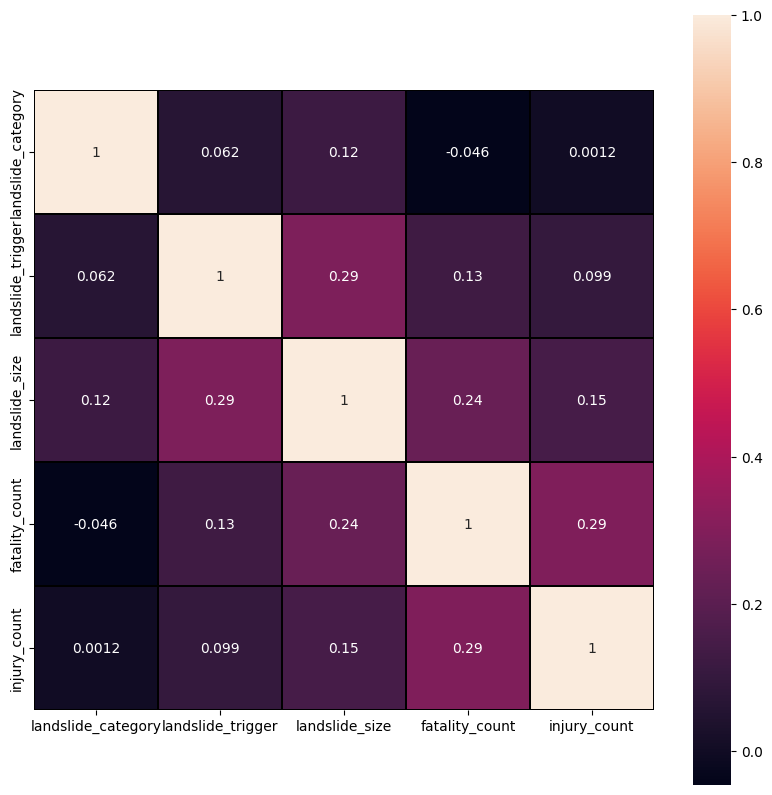

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(data)
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), square = True, annot=True, annot_kws={'fontsize':10}, linewidths=.1, vmax=1, linecolor='black')
plt.show()

With that reminder fresh in my head, it's time to begin working with the data. Arbitrarily, I've decided that I want to predict the injury count, so I'm going to select that to be my target.\
\
That accounts for the first bit of this cell; the rest of it is building hyperparameter search spaces for the four models that I've chosen for experimentation (random forest, SVC, decision tree, and gradient boosting). With any luck, I can use these spaces for each of the search methods that I'm going to implement. 

In [14]:
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

features = data.drop(columns=['injury_count'])
target = data['injury_count']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.2, random_state=85)

'''
RepeatedKFold is here for cross validation. Basically, it splits the data into 10 sections,
then instructs the search algorithm to iterate through training, using a different section each time
as a test section, so as to (hopefully) prevent overfitting.
'''
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=3)


estimators = [int(each) for each in np.linspace(start=100, stop=1000, num=10)]
maxFeatures = ['sqrt', 'log2', None]

minSplit = [2, 6, 12]
minLeaf = [1, 2, 5]
#bootstrap = [True, False]
randomGrid = {'n_estimators':estimators, 'max_features':maxFeatures, 'min_samples_split':minSplit, 'min_samples_leaf':minLeaf}

maxIter = [int(each) for each in np.linspace(start=100, stop=1000, num=10)] + [-1]
gamma = ['scale', 'auto']
degree = [int(each) for each in np.linspace(start=3, stop=15, num=5)]
svcGrid = {'max_iter':maxIter, 'gamma':gamma, 'degree':degree}

splitter = ['best', 'random']
maxDepth = [int(each) for each in np.linspace(5, 115, num=11)] + [None]
dtGrid = {'splitter':splitter, 'max_depth':maxDepth, 'min_samples_split':minSplit, 'min_samples_leaf':minLeaf}

gbGrid = {'max_features':maxFeatures, 'min_samples_leaf':minLeaf, 'min_samples_split':minSplit}

space = [randomGrid, svcGrid, dtGrid, gbGrid]
models = [RandomForestClassifier(), SVC(), DecisionTreeClassifier(), GradientBoostingClassifier()]

With the search spaces initialized, it's time to do some searching.\
First on the list is a basic random search: all that this cell does is loop through each of the models and search 500 times in their search spaces, with an end result that is then fit to the training portion of the landslide data and evaluated on its ability to predict, just like normal. The bit where space[i] is referenced is simply to allow both lists to be iterated at the same time and only when the other one is, so that each model is matched with the correct search space. Is there a better way to do this? Almost certainly. But I'm a C++ guy at heart.\

In [15]:
#randomized search
from time import time #I want to know how long they take
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

randScore = 0
randName = ""
bestRandParams = ""
i = 0
for model in models:
    currentTime = time()
    search = RandomizedSearchCV(model, space[i], n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv)
    i = i + 1
    result = search.fit(features_train, target_train)
    rPred = result.predict(features_test)
    score = accuracy_score(target_test, rPred) * 100
    totalTime = time() - currentTime
    print(str(model) + " with " + str(result.best_params_) + " yields " + str(score) + " percent accuracy")
    print("process took " + str(totalTime) + " seconds.")
    if(score > randScore):
        randScore = score
        randName = model
        bestRandParams = result.best_params_
        

print("The best performing model was " + str(randName) + " with the parameters " + str(bestRandParams) + " and an accuracy of " + str(randScore))

KeyboardInterrupt: 

Several things surprised me about these results. First and formost was the sheer amount of time that it took. I mean, I thought that I must have had an infinite loop in there somewhere when I initially tested this function, so I went back and wrote in time checks. The following is the result of the data with 50 iterations, before I scaled back the number of features:\
\
RandomForestClassifier() with {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 49, 'bootstrap': True} yields 90.9090909090909 percent accuracy\
process took 817.891797542572 seconds.\
SVC() with {'max_iter': -1, 'gamma': 'scale', 'degree': 15} yields 91.29186602870814percent accuracy\
process took 171.1321301460266 seconds.\
DecisionTreeClassifier() with {'splitter': 'random', 'min_samples_split': 12, 'min_samples_leaf': 5, 'max_depth': 5} yields 91.19617224880383percent accuracy\
process took 4.484895944595337 seconds.\
GradientBoostingClassifier() with {'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_features': None} yields 90.622009569378percent accuracy\
process took 33127.306510686874 seconds.\
The best performing model was SVC() with the parameters {'max_iter': -1, 'gamma': 'scale', 'degree': 15} and an accuracy of 91.29186602870814\
\
4.5 seconds is great. 171 is reasonable. 818 is getting a little ridiculous. 33,127 is absolutely insane. I hypothesize that at least some of the issue is due to me running this on my laptop, instead of a rig with higher ram (see also: I'm poor), but regardless, I was forced to scale back the search spaces to run a reasonable amount of iterations.\
\
The other thing that I noticed is the incredibly high accuracies of each classifier. Nowhere in the rest of the class have I seen an accuracy that was HALF as good as these models', and that is no exaggeration. My hypothesis is that this (at least partially) stems from how many landslides are associated with 0 deaths. If I were to meter individual predictions, I would bet that more often than not they return with a prediction of 0, and that 90% of the time they are right.